In [1]:
import sys
sys.path.insert(1, '../../')

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pyei.r_by_c import RowByColumnEI
from pyei.data import Datasets
from pyei.plot_utils import plot_precinct_scatterplot

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
%load_ext autoreload
%autoreload 2

# Demo of RxC models and plotting using Santa Clara data

We show examples of using and examining models available in pyei using a sample data set:

In [6]:
data = Datasets.Santa_Clara.to_dataframe()
precinct_pops = np.array(data['total2'])
votes_fractions = np.array(data[['pct_for_hardy2', 'pct_for_kolstad2', 'pct_for_nadeem2']]).T
candidate_names = ["Hardy", "Kolstad", "Nadeem"]
group_fractions = np.array(data[['pct_ind_vote', 'pct_e_asian_vote', 'pct_non_asian_vote']]).T
demographic_group_names = ["ind", "e_asian", "non_asian"]

In [7]:
ei = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

In [8]:
ei.fit(group_fractions, votes_fractions, precinct_pops, demographic_group_names, candidate_names)

r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi, kappa]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 179 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


## Plotting

<AxesSubplot:title={'center':'Nadeem'}>

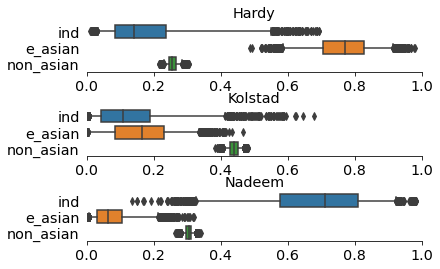

In [9]:
ei.plot_boxplots()

<AxesSubplot:title={'center':'non_asian'}>

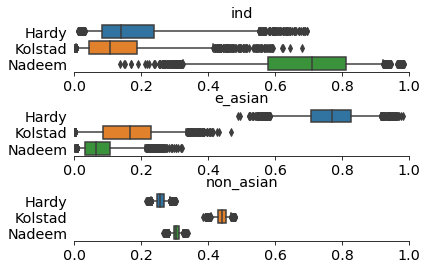

In [10]:
ei.plot_boxplots(plot_by="group")

<AxesSubplot:title={'center':'Nadeem'}, ylabel='Density'>

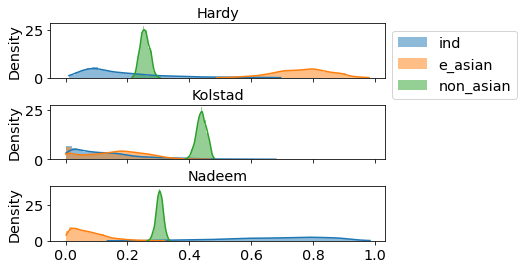

In [11]:
ei.plot_kdes(plot_by="candidate")

<AxesSubplot:title={'center':'non_asian'}, ylabel='Density'>

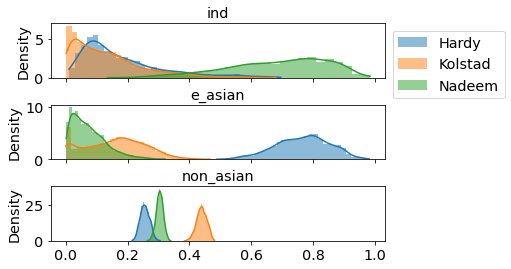

In [12]:
ei.plot_kdes(plot_by="group")

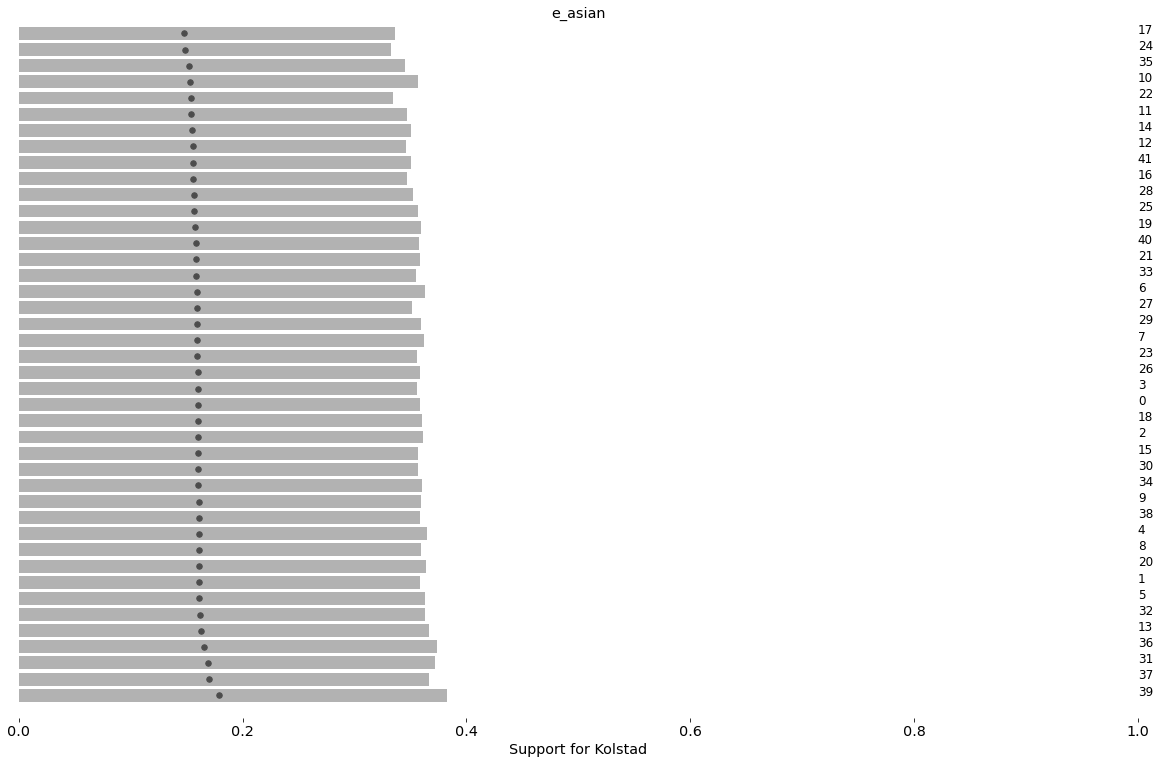

In [13]:
ei.plot_intervals_by_precinct('e_asian', 'Kolstad') # 95% credible intervals by precinct

## Plotting across EI runs
Let's see how different `multinomial-dirichlet-modified` is from `multinomial-dirichlet`

In [14]:
ei_not_modified = RowByColumnEI(model_name='multinomial-dirichlet')

In [15]:
ei_not_modified.fit(group_fractions, votes_fractions, precinct_pops, demographic_group_names, candidate_names)

r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, conc_params]


KeyboardInterrupt: 

In [ ]:
ei_runs = [ei, ei_not_modified]
run_names = ['multinomial-dirichlet-modified', 'multinomial-dirichlet']

In [ ]:
plot_precinct_scatterplot(ei_runs, run_names, "Nadeem", "e_asian")

In [ ]:
plot_precinct_scatterplot(ei_runs, run_names, "Nadeem")

This tells us that the `multinomial-dirichlet` version seemed to overestimate Nadeem's support among East Asians and underestimate Nadeem's support among Indians, relative to the `multinomial-dirichlet-modified` version.

## Summaries
Text summaries and summary statistics

In [ ]:
print(ei.summary())

In [45]:
print(ei.candidate_of_choice())

ind
In 0.116 of samples, the district-level vote preference of
                    ind for Hardy
                    was higher than for any other candidate
In 0.054 of samples, the district-level vote preference of
                    ind for Kolstad
                    was higher than for any other candidate
In 0.83 of samples, the district-level vote preference of
                    ind for Nadeem
                    was higher than for any other candidate
e_asian
In 0.9985 of samples, the district-level vote preference of
                    e_asian for Hardy
                    was higher than for any other candidate
In 0.00125 of samples, the district-level vote preference of
                    e_asian for Kolstad
                    was higher than for any other candidate
In 0.00025 of samples, the district-level vote preference of
                    e_asian for Nadeem
                    was higher than for any other candidate
non_asian
In 0.0 of samples, the district-level 

### Posterior means of voting preference for each group/candidate:

In [46]:
posterior_mean_voting_prefs = ei.posterior_mean_voting_prefs
df = pd.DataFrame(posterior_mean_voting_prefs, columns=candidate_names, index=demographic_group_names)
df.head()

,Hardy,Kolstad,Nadeem
ind,0.230908,0.186901,0.582190
e_asian,0.760939,0.145372,0.093689
non_asian,0.254738,0.439615,0.305648


### 95% Credible interval for voting preferences for each group:

In [47]:
num_groups, num_candidates = ei.num_groups_and_num_candidates # R, C
credible_interval_95_mean_voting_prefs = ei.credible_interval_95_mean_voting_prefs
for r in range(num_groups):
    for c in range(num_candidates):
        print(demographic_group_names[r],candidate_names[c], credible_interval_95_mean_voting_prefs[r][c])

ind Hardy [0.03317976 0.5890966 ]
ind Kolstad [0.01974606 0.4995427 ]
ind Nadeem [0.19601765 0.86222612]
e_asian Hardy [0.56034474 0.90787325]
e_asian Kolstad [0.02263557 0.36030772]
e_asian Nadeem [0.01408444 0.23737461]
non_asian Hardy [0.22856915 0.2882032 ]
non_asian Kolstad [0.40225413 0.46379441]
non_asian Nadeem [0.28268026 0.32621014]


### Precinct-level means and credible intervals:

In [137]:
precinct_posterior_means, precinct_credible_intervals = ei.precinct_level_estimates()
# Note: precinct_posterior_means is shape num_precincts x r x c
# Note: precinct_credible_intervals is shape num_precincts x r x c x 2 
r = 0
c= 0
print(f'Precinct support for {candidate_names[c]} among {demographic_group_names[r]}')
print(precinct_posterior_means[:,r,c])
print(f'95% credible intervals of precinct support for {candidate_names[c]} among {demographic_group_names[r]}')
print(precinct_credible_intervals[:,r,c])

Precinct support for Hardy among ind
[0.3242682  0.32391841 0.31494351 0.3103517  0.32016069 0.33875116
 0.32021428 0.31529159 0.32712157 0.32682074 0.32620924 0.32641294
 0.31819674 0.32142037 0.32599578 0.3164146  0.31537516 0.328641
 0.32226117 0.32954586 0.3243104  0.32560522 0.32350337 0.32903245
 0.32278877 0.3213012  0.32356853 0.33949287 0.31983999 0.32203333
 0.31363913 0.31706366 0.31892819 0.32154322 0.33182261 0.32598311
 0.32452829 0.32274682 0.32256456 0.31010542 0.32203064 0.32666616]
95% credible intervals of precinct support for Hardy among ind
[[0.23230972 0.42716065]
 [0.22267113 0.42665711]
 [0.2336408  0.40182498]
 [0.19770481 0.43431305]
 [0.23122841 0.45882289]
 [0.24511611 0.46497578]
 [0.23970807 0.45832347]
 [0.22710944 0.42707122]
 [0.22303511 0.4436415 ]
 [0.22964674 0.41540575]
 [0.23125053 0.44351165]
 [0.24840523 0.41657801]
 [0.20778715 0.4340077 ]
 [0.23844954 0.4061792 ]
 [0.22822596 0.40337809]
 [0.21348141 0.41969478]
 [0.19975524 0.46557984]
 [0.243

## Samples

Samples from the posterior are accessible. 

Precinct level samples are aggregated into district level preference samples by weighting each precinct by its population:

In [36]:
ei.sampled_voting_prefs.shape # ei.sampled_voting_prefs is samples of district-level voter preference: num_samples x r x c

(4000, 3, 3)

Samples can also be obtained directly by the parameter name in the model:

In [37]:
ei.sim_trace["b"].shape # ei.sim_trace["b"] is samples of precinct-level voter preference: num_samples x num_precincts x r x c

(4000, 42, 3, 3)

Samples of hyperparameters are available:

In [24]:
ei.sim_trace["kappa"].mean(axis=0)

array([ 581.11401859, 2147.80233865,  120.41527166])

### Accessing (and visualizing) the pymc model

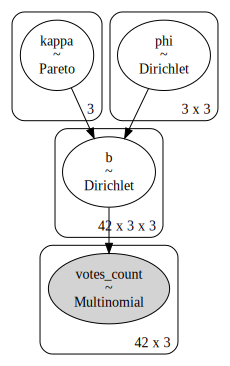

In [17]:
model = ei.sim_model
pm.model_to_graphviz(model)